In [1]:
import pandas as pd
from datetime import datetime

# Function to process the RFM file
def process_rfm_file(file):
    # Load the data into a DataFrame
    df = pd.read_csv(file)

    # Remove the time part (if any) and convert ORDERDATE to datetime
    df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'], errors='coerce', dayfirst=False)

    # Get today's date
    today = datetime.today()

    # Calculate Recency (days since last order)
    recency_df = df.groupby('CUSTOMERNAME')['ORDERDATE'].max().reset_index()
    recency_df['Recency'] = (today - recency_df['ORDERDATE']).dt.days

    # Calculate Frequency (number of orders per customer)
    frequency_df = df.groupby('CUSTOMERNAME')['ORDERNUMBER'].nunique().reset_index()
    frequency_df.rename(columns={'ORDERNUMBER': 'Frequency'}, inplace=True)

    # Calculate Monetary (total sales per customer)
    monetary_df = df.groupby('CUSTOMERNAME')['SALES'].sum().reset_index()
    monetary_df.rename(columns={'SALES': 'Monetary'}, inplace=True)

    # Merge the three DataFrames
    rfm_df = recency_df.merge(frequency_df, on='CUSTOMERNAME').merge(monetary_df, on='CUSTOMERNAME')

    # Create a function to assign segments based on RFM values
    def assign_segment(row):
        # Use quantiles to categorize the customers into segments
        recency_quartiles = rfm_df['Recency'].quantile([0.25, 0.5, 0.75])
        frequency_quartiles = rfm_df['Frequency'].quantile([0.25, 0.5, 0.75])
        monetary_quartiles = rfm_df['Monetary'].quantile([0.25, 0.5, 0.75])

        # Assign segments based on recency, frequency, and monetary value
        if row['Recency'] <= recency_quartiles[0.25] and row['Frequency'] >= frequency_quartiles[0.75] and row['Monetary'] >= monetary_quartiles[0.75]:
            return 'VIP'
        elif row['Recency'] > recency_quartiles[0.75] and row['Frequency'] <= frequency_quartiles[0.25] and row['Monetary'] <= monetary_quartiles[0.25]:
            return 'Lost'
        elif row['Recency'] <= recency_quartiles[0.25] and row['Frequency'] <= frequency_quartiles[0.25] and row['Monetary'] >= monetary_quartiles[0.75]:
            return 'High Value, Low Recency'
        elif row['Recency'] <= recency_quartiles[0.25] and row['Frequency'] >= frequency_quartiles[0.75] and row['Monetary'] <= monetary_quartiles[0.25]:
            return 'New High Frequency'
        elif row['Recency'] > recency_quartiles[0.75] and row['Frequency'] >= frequency_quartiles[0.75] and row['Monetary'] <= monetary_quartiles[0.25]:
            return 'Loyal but Low Spend'
        elif row['Recency'] <= recency_quartiles[0.25] and row['Frequency'] >= frequency_quartiles[0.25] and row['Monetary'] <= monetary_quartiles[0.25]:
            return 'Engaged but Low Spend'
        else:
            return 'Other'

    # Apply the segment function to the dataframe
    rfm_df['Segment'] = rfm_df.apply(assign_segment, axis=1)

    # Display the RFM DataFrame with segments
    print(rfm_df)
    return rfm_df

# Manually set the file path
file_path = r"path\file_name.csv"  # Provide your file path here

# Clean up the file path by removing unwanted characters
file_path = file_path.strip()  # Remove extra spaces
file_path = file_path.replace("\u202a", "")  # Remove any unwanted invisible characters

# Check if the file path is valid
print(f"Selected file: {file_path}")

# Process the uploaded file
if file_path:
    rfm_data = process_rfm_file(file_path)
    rfm_data.to_csv('rfm_output_with_segments.csv', index=False)
    print("RFM Analysis complete. Results saved to 'rfm_output_with_segments.csv'.")


Selected file: C:\Users\Kimso\Downloads\test.csv
                   CUSTOMERNAME  ORDERDATE  Recency  Frequency   Monetary  \
0                AV Stores, Co. 2004-11-17     7599          3  157807.81   
1                  Alpha Cognac 2005-03-28     7468          3   70488.44   
2            Amica Models & Co. 2004-09-09     7668          2   94117.26   
3       Anna's Decorations, Ltd 2005-03-09     7487          4  153996.13   
4             Atelier graphique 2004-11-25     7591          3   24179.96   
..                          ...        ...      ...        ...        ...   
87              Vida Sport, Ltd 2004-08-30     7678          2  117713.56   
88              Vitachrome Inc. 2004-11-05     7611          3   88041.26   
89     Volvo Model Replicas, Co 2004-11-19     7597          4   75754.88   
90  West Coast Collectables Co. 2004-01-29     7892          2   46084.64   
91            giftsbymail.co.uk 2004-11-01     7615          2   78240.84   

   Segment  
0    Other  


C:\Users\Kimso\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


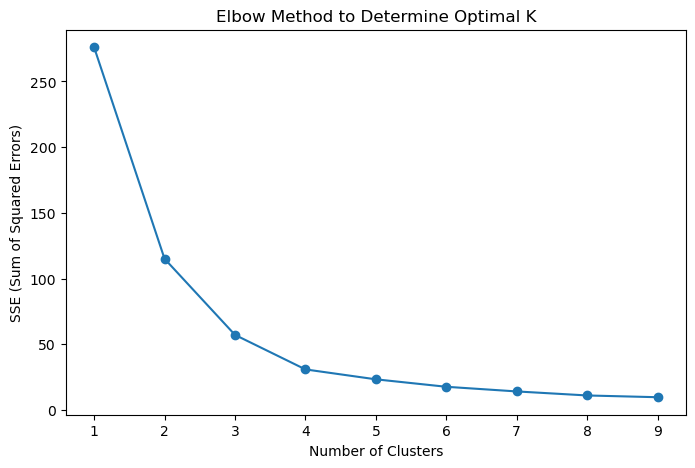

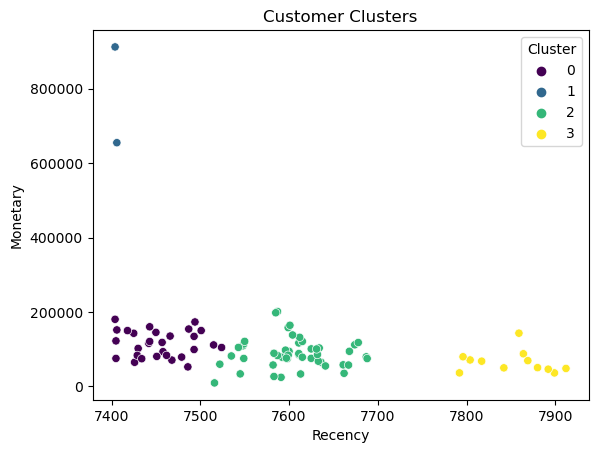

K-Means clustering complete. Results saved to 'rfm_kmeans_clusters.csv'.


In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the RFM data
rfm_data = pd.read_csv("rfm_output_with_segments.csv")

# Normalize the RFM values for clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data[['Recency', 'Frequency', 'Monetary']])

# Use the Elbow Method to determine optimal K
sse = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    sse.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('Elbow Method to Determine Optimal K')
plt.show()

# Fit K-Means with the optimal K (choose based on elbow point)
optimal_k = 4  # You can change based on the elbow plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm_data['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Visualize the clusters
sns.scatterplot(data=rfm_data, x="Recency", y="Monetary", hue="Cluster", palette="viridis")
plt.title("Customer Clusters")
plt.show()

# Save the clustered RFM data
rfm_data.to_csv("rfm_kmeans_clusters.csv", index=False)
print("K-Means clustering complete. Results saved to 'rfm_kmeans_clusters.csv'.")


In [3]:
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter

# Load RFM Data
rfm_data = pd.read_csv("rfm_output_with_segments.csv")

# Train the BG/NBD Model (predicting how often customers will buy again)
bgf = BetaGeoFitter()
bgf.fit(rfm_data['Frequency'], rfm_data['Recency'], rfm_data['Monetary'])

# Predict number of transactions in next 6 months
rfm_data['Predicted_Purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(180, 
                                                                                         rfm_data['Frequency'], 
                                                                                         rfm_data['Recency'], 
                                                                                         rfm_data['Monetary'])

# Train the Gamma-Gamma Model (predicting spending value)
ggf = GammaGammaFitter()
ggf.fit(rfm_data['Frequency'], rfm_data['Monetary'])

# Predict average future spending per transaction
rfm_data['Predicted_Monetary'] = ggf.conditional_expected_average_profit(rfm_data['Frequency'], 
                                                                         rfm_data['Monetary'])

# Compute Customer Lifetime Value
rfm_data['CLV'] = rfm_data['Predicted_Purchases'] * rfm_data['Predicted_Monetary']



In [4]:
rfm_data

,CUSTOMERNAME,ORDERDATE,Recency,Frequency,Monetary,Segment,Predicted_Purchases,Predicted_Monetary,CLV
0,"AV Stores, Co.",2004-11-17,7599,3,157807.81,Other,2.871319e-11,143509.039531,4.120602e-06
1,Alpha Cognac,2005-03-28,7468,3,70488.44,Other,7.850162e-08,82146.808692,6.448658e-03
2,Amica Models & Co.,2004-09-09,7668,2,94117.26,Other,2.207652e-08,100169.201478,2.211387e-03
3,"Anna's Decorations, Ltd",2005-03-09,7487,4,153996.13,Other,5.575255e-12,143329.130349,7.990964e-07
4,Atelier graphique,2004-11-25,7591,3,24179.96,Other,4.751266e-04,49604.296767,2.356832e+01
...,...,...,...,...,...,...,...,...,...
87,"Vida Sport, Ltd",2004-08-30,7678,2,117713.56,Other,2.925862e-09,114605.406385,3.353196e-04
88,Vitachrome Inc.,2004-11-05,7611,3,88041.26,Other,1.017145e-08,94481.760178,9.610168e-04
89,"Volvo Model Replicas, Co",2004-11-19,7597,4,75754.88,Other,1.237749e-08,83932.216055,1.038870e-03
90,West Coast Collectables Co.,2004-01-29,7892,2,46084.64,Lost,9.222202e-06,70782.867835,6.527739e-01


In [5]:
# Save the CLV segmentation output
rfm_data.to_csv("rfm_with_clv.csv", index=False)
print("CLV Segmentation complete. Results saved to 'rfm_with_clv.csv'.")

CLV Segmentation complete. Results saved to 'rfm_with_clv.csv'.
